In [204]:
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import statsmodels.api as sm
import SOG_loader
import carbonate
import yaml
import os
from datetime import datetime, timedelta
from dateutil.parser import parse
from scipy import signal
from scipy.io import loadmat
from matplotlib import gridspec

%matplotlib inline

In [2]:
# Load GRL2016 data
infil = np.loadtxt('/home/bmoorema/Desktop/grl2016.raw')
crid = infil[:,0]
stn = infil[:,3]
mnth = infil[:,4]
day = infil[:,5]
S = infil[:,10]
alk = infil[:,15]
alk_qf = infil[:,16]

In [3]:
# Load Fraser Record
R = loadmat('/ocean/rich/home/metro/fraser/FRASER.mat')
dates = [
    datetime.fromordinal(int(mtime[0]) - 366) +
    timedelta(days=float(mtime)%1)
    for mtime in R['fraser'][0][0][1]
]
flows = R['fraser'][0][0][2].flatten()

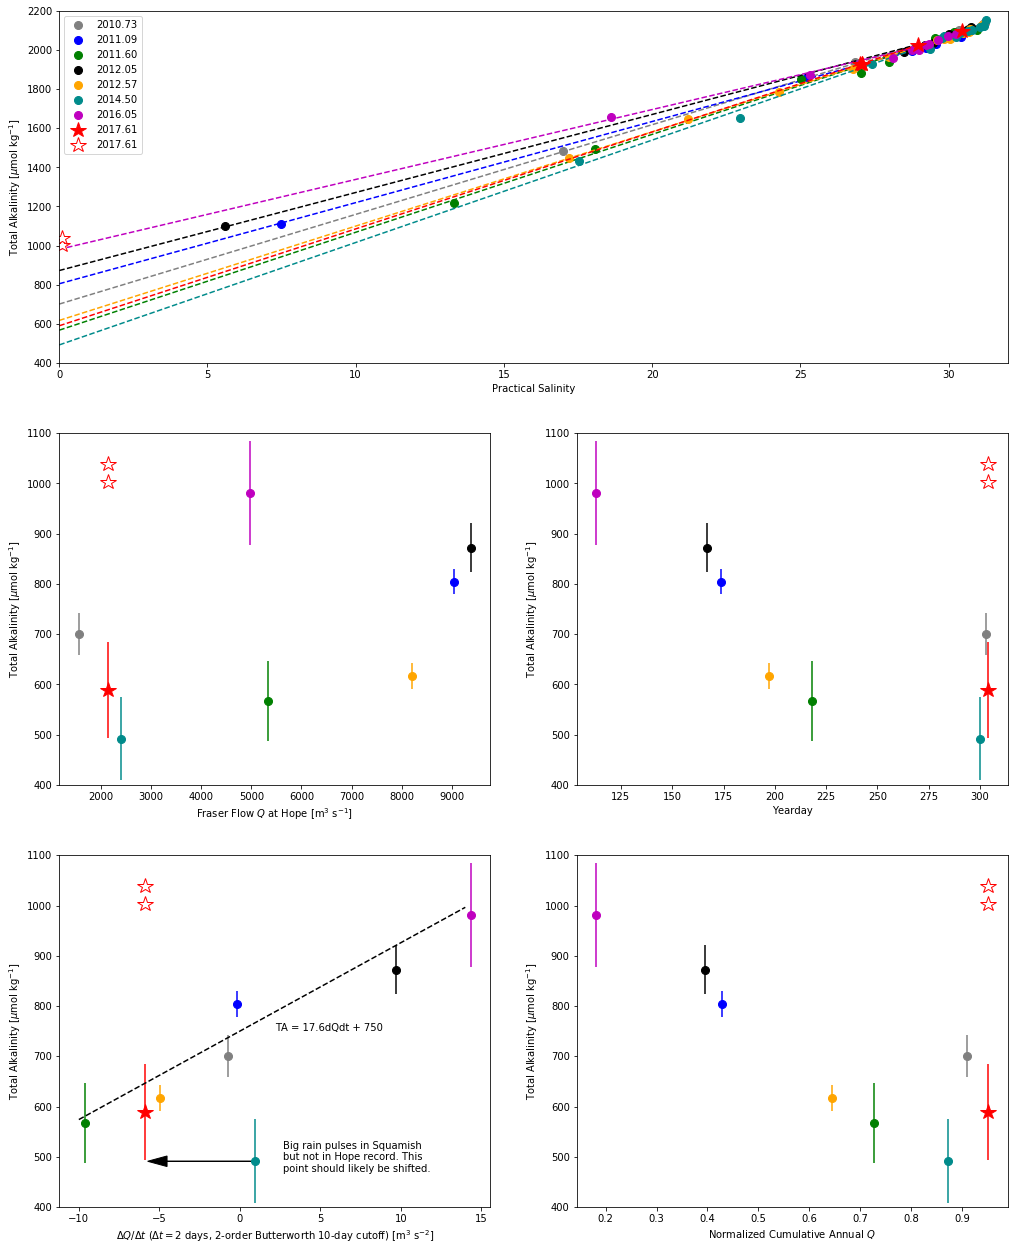

In [4]:
# Cruises to plot
cruises = [2010.73, 2011.09, 2011.60, 2012.05, 2012.57, 2014.50, 2016.05, 2017.61, 2017.61]
stations = [39.5, 42., 39.5, 42., 39.5, 42., 42., 1.5, 0.5]
colors = ['gray', 'b', 'g', 'k', 'orange', 'darkcyan', 'm', 'r', 'r']

# Make figure
fig = plt.figure(figsize=(17, 22))
gs = gridspec.GridSpec(3, 2)
axs = [fig.add_subplot(gs[0, :])]
axs.extend([fig.add_subplot(gs[1, col]) for col in range(2)])
axs.extend([fig.add_subplot(gs[2, col]) for col in range(2)])

# Plot Formatting and Labels
axs[0].set_xlim([0, 32])
axs[0].set_ylim([400, 2200])
axs[0].set_xlabel('Practical Salinity')
axs[0].set_ylabel('Total Alkalinity [$\mu$mol kg$^{-1}$]')
labels = [
    'Fraser Flow $Q$ at Hope [m$^3$ s$^{-1}$]',
    'Yearday',
    '$\Delta Q/\Delta t$ ($\Delta t = 2$ days, 2-order Butterworth 10-day cutoff) [m$^{3}$ s$^{-2}$]',
    'Normalized Cumulative Annual $Q$',
]
for ax, label in zip(axs[1:], labels):
    ax.set_ylim([400, 1100])
    ax.set_xlabel(label)
    ax.set_ylabel('Total Alkalinity [$\mu$mol kg$^{-1}$]')

x_reg, y_reg = [], []    

# Loop through cruises
for cruise, station, color, flow in zip(cruises, stations, colors, flows):
    
    # Symbols
    if color is 'r':
        marker = '*'
        size = 16
    else:
        marker = 'o'
        size = 8
    
    # Index
    index = (crid == cruise) & (stn == station) & ((alk_qf == 2) | (alk_qf == 6))
    
    # Regressions
    if station == 0.5:
        facecolor = 'w'
    else:
        facecolor = color
        model = sm.OLS(alk[index], sm.add_constant(S[index])).fit()
    
    # Flow metrics
    B, A = signal.butter(2, 0.2)
    flows_filter = signal.filtfilt(B, A, flows)
    W2 = 3
    flowindex = abs(np.array(dates) - datetime(int(cruise), int(mnth[index][0]), int(day[index][0]))).argmin()
    yearstart = abs(np.array(dates) - datetime(int(cruise), 1, 1)).argmin()
    yearend = abs(np.array(dates) - datetime(int(cruise), 12, 31)).argmin()
    #dQdt = np.diff(flows[flowindex-W2: flowindex+W2]).mean()/len(flows[flowindex-W2: flowindex+W2])
    dQdt = (flows_filter[flowindex+1] - flows_filter[flowindex-1]) / (2 * 24)
    intQ = flows[yearstart:flowindex].sum()/flows[yearstart:yearend].sum()
    
    # Salinity Regression Plot
    axs[0].plot(
        S[index], alk[index],
        marker=marker, color=color,
        markersize=size, markerfacecolor=facecolor,
        linestyle='', label=f'{cruise:.2f}',
    )
    if station != 0.5:
        axs[0].plot(np.arange(30), model.params[1] * np.arange(30) + model.params[0], linestyle='--', color=color)
    
    # Endmember Plots
    metrics = [flows[flowindex], (dates[flowindex] - dates[yearstart]).days, dQdt, intQ]
    for i, ax, x in zip(range(4), axs[1:], metrics):
        if station == 0.5:
            ax.plot(
                x*np.ones(sum(index)), alk[index],
                marker=marker, color=color,
                markerfacecolor=facecolor, markersize=size, linestyle='',
            )
        else:
            ax.plot(x, model.params[0], marker=marker, color=color, markerfacecolor=facecolor, markersize=size)
            ax.errorbar(x, model.params[0], model.conf_int()[0][1] - model.params[0], color=color)
            if i == 2 and cruise != 2014.50:
                x_reg.append(x)
                y_reg.append(model.params[0])
                
model2 = sm.OLS(np.array(y_reg), sm.add_constant(np.array(x_reg))).fit()
axs[3].plot(np.arange(-10, 15), 17.6 * np.arange(-10, 15) + 750, 'k--')
axs[3].text(0.5, 0.5, f'TA = {model2.params[1]:.1f}dQdt + {750}', transform=axs[3].transAxes)
axs[3].text(0.52, 0.1, 'Big rain pulses in Squamish\nbut not in Hope record. This\npoint should likely be shifted.', transform=axs[3].transAxes)
axs[3].arrow(0.45, 0.13, -0.2, 0, head_width=0.03, fc='k', transform=axs[3].transAxes)
axs[0].legend()
plt.show()

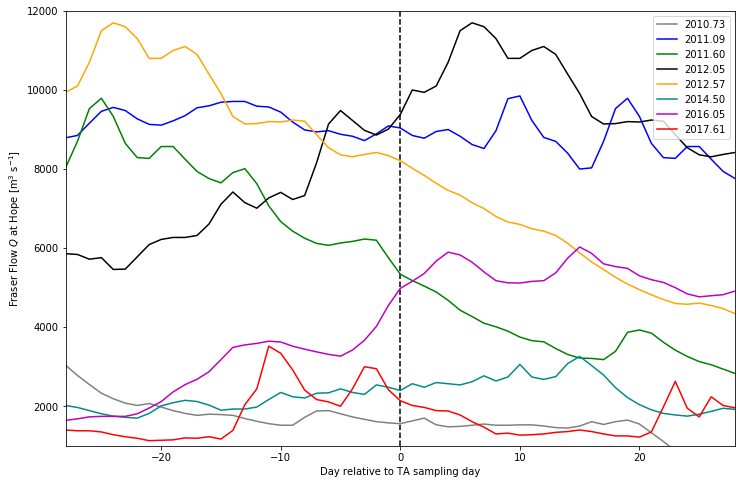

In [7]:
# Make Figure
fig, ax = plt.subplots(figsize=(12, 8))
ax.plot([0, 0], [1000, 12000], 'k--')
ax.set_xlim([-28, 28])
ax.set_ylim([1000, 12000])
ax.set_xlabel('Day relative to TA sampling day')
ax.set_ylabel('Fraser Flow $Q$ at Hope [m$^3$ s$^{-1}$]')

# Loop through cruises
for cruise, station, color in zip(cruises[:-1], stations, colors):
    
    # Plot 40 day flow record
    index = (crid == cruise) & (stn == station) & ((alk_qf == 2) | (alk_qf == 6))
    flowindex = abs(np.array(dates) - datetime(int(cruise), int(mnth[index][0]), int(day[index][0]))).argmin()
    ax.plot(range(-28, 29), flows[flowindex-28:flowindex+29], color=color, label=f'{cruise:.2f}')

ax.legend(loc=1)
plt.show()

Text(0.1,0.9,'728.89')

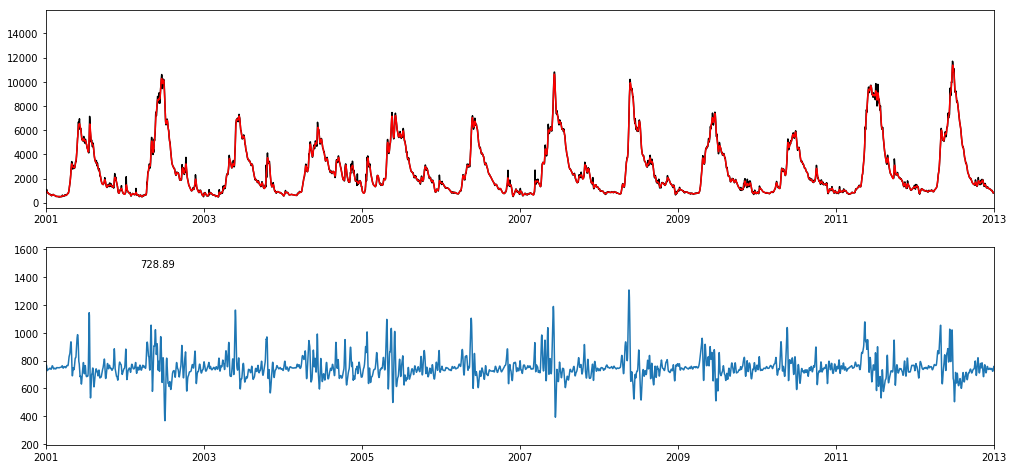

In [8]:
flowlims = [abs(np.array(dates) - parse(date)).argmin() for date in ['2001 Jan 1', '2013 Jan 1']]

dQdt = np.diff(flows_filter)/24


fig, ax = plt.subplots(2, 1, figsize=(17, 8))
ax[0].plot(dates, flows, 'k-')
ax[0].plot(dates, flows_filter, 'r-')
ax[0].set_xlim(['2001 Jan 1', '2013 Jan 1'])

ax[1].plot(dates[1:], 17.6*dQdt + 750)
ax[1].set_xlim(['2001 Jan 1', '2013 Jan 1'])
ax[1].text(0.1, 0.9, f'{(7.59*dQdt[flowlims] + 726.46).mean():.2f}', transform=ax[1].transAxes)

In [34]:
# Create new forcing file
Fraser = pd.read_csv(
    '/ocean/bmoorema/research/SOG/SOG-forcing/rivers/Fraser_total_31May2013.dat',
    delim_whitespace=True, names=['year', 'month', 'day', 'flow'],
)
B, A = signal.butter(2, 0.2)
filtered = signal.filtfilt(B, A, Fraser['flow'])
dQdt = 17.6 * np.diff(filtered)/24 + 750
dQdt = pd.DataFrame(np.append(dQdt[0], dQdt), columns=['TA'])
Fraser = Fraser.join(dQdt)

#Fraser.to_csv('/ocean/bmoorema/research/SOG/SOG-forcing/rivers/FraserTA.dat', sep=' ', header=False, index=False)

In [260]:
with open('/ocean/bmoorema/research/SOG/SOG-runsets/river_chemistry/run_list.yaml', 'r') as f:
    run_list = yaml.load(f)

In [279]:
TAruns = {
    '74': {
        '500': {},
        '750': {},
        '1000': {},
        'var': {},
    },
    '77': {
        '500': {},
        '750': {},
        '1000': {},
        'var': {},
    },
    '80': {
        '500': {},
        '750': {},
        '1000': {},
        'var': {},
    },
}

In [280]:
for path in run_list['run_list']:
    TS_phys = SOG_loader.load_TS(os.path.join(path, 'timeseries/std_phys_SOG.out'))
    TS_chem = SOG_loader.load_TS(os.path.join(path, 'timeseries/std_chem_SOG.out'))
    key = os.path.split(path)[1]
    year = key.split('_')[0]
    chemstr = key.split('TA')[1].split('pH')
    TA = chemstr[0]
    pH = chemstr[1]
    TAruns[pH][TA][year] = {}
    TAruns[pH][TA][year]['DIC'] = TS_chem['3 m avg DIC concentration']
    TAruns[pH][TA][year]['TA'] = TS_chem['3 m avg alkalinity']
    TAruns[pH][TA][year]['Salinity'] = TS_phys['3 m avg salinity']

In [273]:
years = list(TAruns['74']['500'].keys())
TAs = list(TAruns['74'].keys())
pHs = list(TAruns.keys())

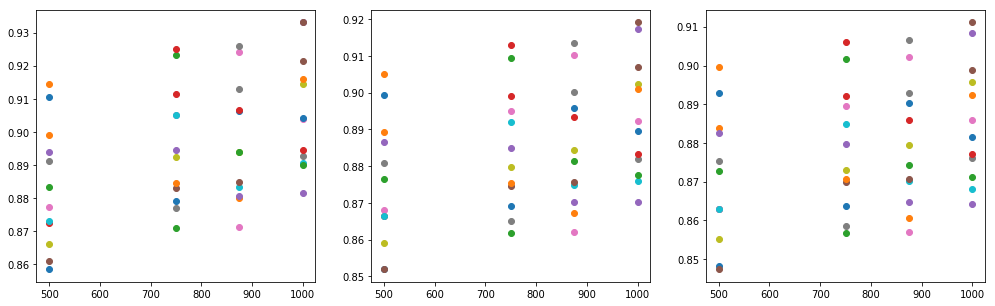

In [295]:
fig, axs = plt.subplots(1, 3, figsize=(17, 5))

for ax, pH in zip(axs, pHs):
    for TA in TAs:
        if TA is 'var':
            xTA = 875
        else:
            xTA = int(TA)
        for year in years:
            index = TAruns[pH][TA][year]['Salinity'] < 20
            dicta = TAruns[pH][TA][year]['DIC'][index]/TAruns[pH][TA][year]['TA'][index]
            ax.plot(xTA, dicta.mean(), 'o')